In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def analyze_files(file_paths, 
                  x_col='Hemorrhage Rate %/Time', 
                  y_cols=None):
    """
    Analyze multiple Excel files with curve fits (linear, quadratic, exponential).

    Parameters
    ----------
    file_paths : list of str
        Paths to Excel files.
    x_col : str
        Column name for x-axis values.
    y_cols : list of str
        Columns to analyze against x_col.
    """

    if y_cols is None:
        y_cols = [
            'Stroke Work',
            'Stroke Volume',
            'Ejection Fraction',
            'Heart Rate',
            'Cardiac Output'
        ]

    # Define exponential function
    def exp_func(x, a, b, c):
        return a * np.exp(b * x) + c

    tick_positions = [0.0, 1/3, 2/3, 1.0]
    tick_labels = ['0', '1/3', '2/3', '1']

    for file_path in file_paths:
        print(f"\n=== Processing {file_path} ===")
        df = pd.read_excel(file_path)

        # Normalize x-axis
        x_min, x_max = df[x_col].min(), df[x_col].max()
        df['Normalized X'] = (df[x_col] - x_min) / (x_max - x_min)
        grouped = df.groupby('Normalized X')

        for y_col in y_cols:
            if y_col not in df.columns:
                print(f"Column '{y_col}' not found in {file_path}. Skipping.")
                continue

            means = grouped[y_col].mean()
            stds = grouped[y_col].std()
            x_vals = means.index

            valid = ~(means.isna() | stds.isna())
            x_clean = x_vals[valid]
            y_mean = means[valid]
            y_std = stds[valid]

            if len(x_clean) < 3:
                print(f"Not enough data for {y_col} in {file_path}.")
                continue

            # ---- Linear & Quadratic fits ----
            linear_coeffs = np.polyfit(x_clean, y_mean, 1)
            quad_coeffs = np.polyfit(x_clean, y_mean, 2)

            y_linear_pred = np.polyval(linear_coeffs, x_clean)
            y_quad_pred = np.polyval(quad_coeffs, x_clean)

            ss_tot = np.sum((y_mean - np.mean(y_mean)) ** 2)
            r2_linear = 1 - np.sum((y_mean - y_linear_pred) ** 2) / ss_tot
            r2_quad = 1 - np.sum((y_mean - y_quad_pred) ** 2) / ss_tot

            # ---- Exponential fit ----
            try:
                popt, _ = curve_fit(exp_func, x_clean, y_mean, maxfev=5000)
                y_exp_pred = exp_func(x_clean, *popt)
                r2_exp = 1 - np.sum((y_mean - y_exp_pred) ** 2) / ss_tot
            except RuntimeError:
                popt = None
                r2_exp = np.nan

            # Smooth x for plotting fits
            x_fit = np.linspace(0, 1, 200)
            y_linear_fit = np.polyval(linear_coeffs, x_fit)
            y_quad_fit = np.polyval(quad_coeffs, x_fit)
            y_exp_fit = exp_func(x_fit, *popt) if popt is not None else None

            # ---- Plot ----
            plt.figure(figsize=(8, 6))
            plt.errorbar(x_clean, y_mean, yerr=y_std, fmt='o', 
                         label='Mean ± SD', color='black', capsize=5)
            plt.plot(x_fit, y_linear_fit, '--', label=f'Linear (R²={r2_linear:.3f})', color='blue')
            plt.plot(x_fit, y_quad_fit, '-.', label=f'Quadratic (R²={r2_quad:.3f})', color='red')
            if y_exp_fit is not None:
                plt.plot(x_fit, y_exp_fit, ':', label=f'Exponential (R²={r2_exp:.3f})', color='green')

            plt.xlabel(x_col)
            plt.ylabel(y_col)
            plt.title(f'{y_col} vs {x_col}\n{file_path}')
            plt.grid(True, which='both', linestyle='--', linewidth=0.5)
            plt.xticks(tick_positions, tick_labels)
            plt.legend()
            plt.tight_layout()
            plt.show()

            # ---- Print equations ----
            print(f"\n--- {y_col} ---")
            print(f"Linear fit:    y = {linear_coeffs[0]:.4f}x + {linear_coeffs[1]:.4f}     R² = {r2_linear:.4f}")
            print(f"Quadratic fit: y = {quad_coeffs[0]:.4f}x² + {quad_coeffs[1]:.4f}x + {quad_coeffs[2]:.4f}     R² = {r2_quad:.4f}")
            if popt is not None:
                print(f"Exponential fit: y = {popt[0]:.4f} * exp({popt[1]:.4f}x) + {popt[2]:.4f}     R² = {r2_exp:.4f}")




=== Processing PV_Fractional_Increase_T0-1.xlsx ===


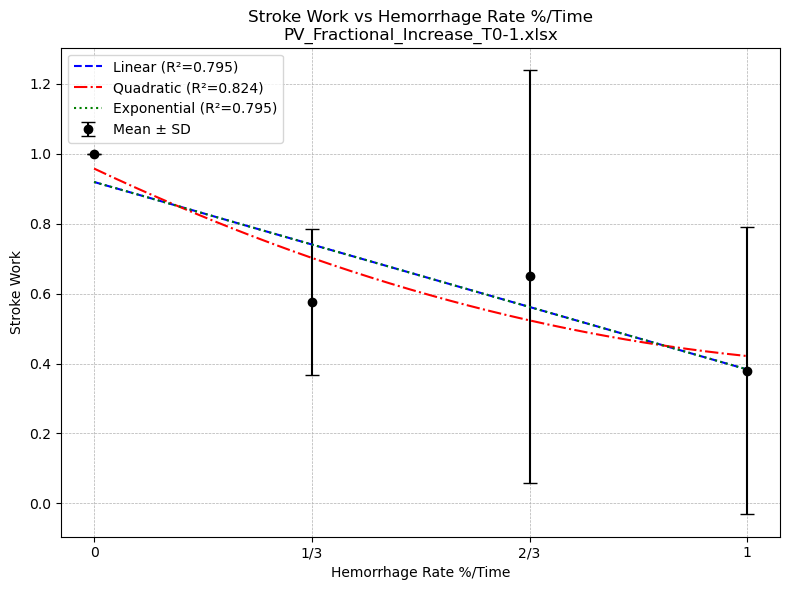


--- Stroke Work ---
Linear fit:    y = -0.5365x + 0.9196     R² = 0.7952
Quadratic fit: y = 0.3454x² + -0.8820x + 0.9580     R² = 0.8245
Exponential fit: y = -1150.7559 * exp(0.0005x) + 1151.6755     R² = 0.7952


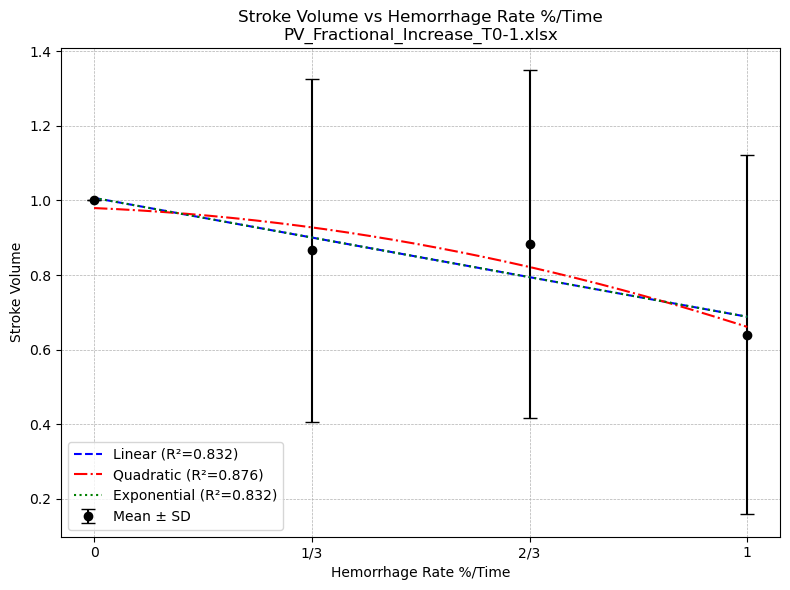


--- Stroke Volume ---
Linear fit:    y = -0.3185x + 1.0067     R² = 0.8325
Quadratic fit: y = -0.2447x² + -0.0738x + 0.9795     R² = 0.8762
Exponential fit: y = 998.2900 * exp(-0.0003x) + -997.2833     R² = 0.8325


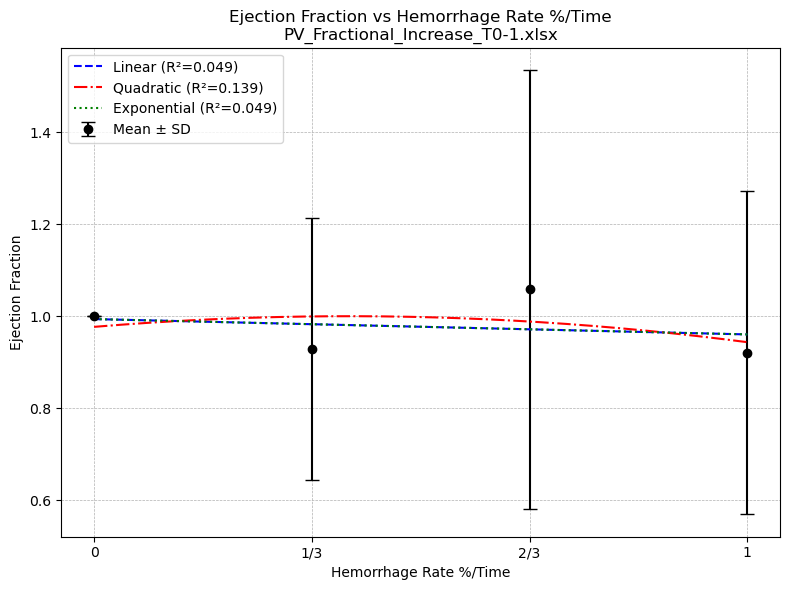


--- Ejection Fraction ---
Linear fit:    y = -0.0333x + 0.9935     R² = 0.0486
Quadratic fit: y = -0.1521x² + 0.1188x + 0.9766     R² = 0.1386
Exponential fit: y = 76.3124 * exp(-0.0004x) + -75.3189     R² = 0.0486


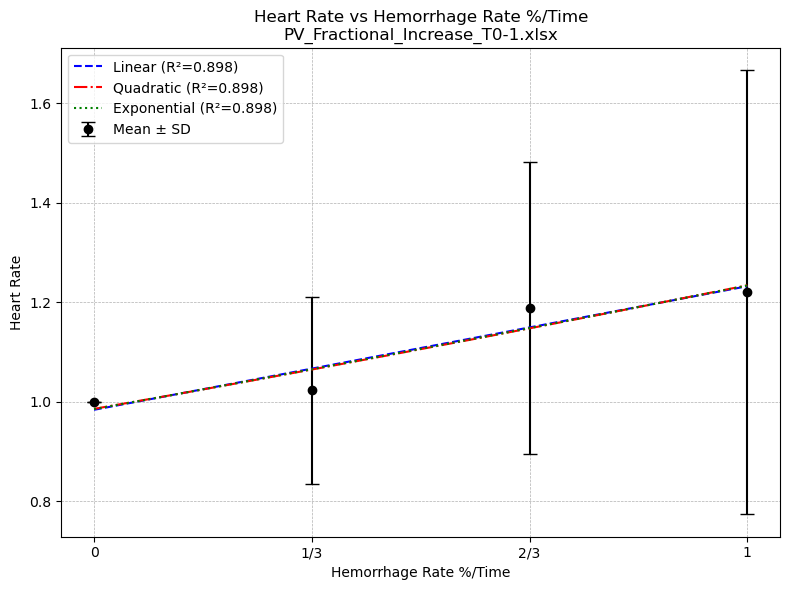


--- Heart Rate ---
Linear fit:    y = 0.2483x + 0.9842     R² = 0.8981
Quadratic fit: y = 0.0168x² + 0.2315x + 0.9861     R² = 0.8984
Exponential fit: y = 2.3339 * exp(0.1011x) + -1.3483     R² = 0.8984


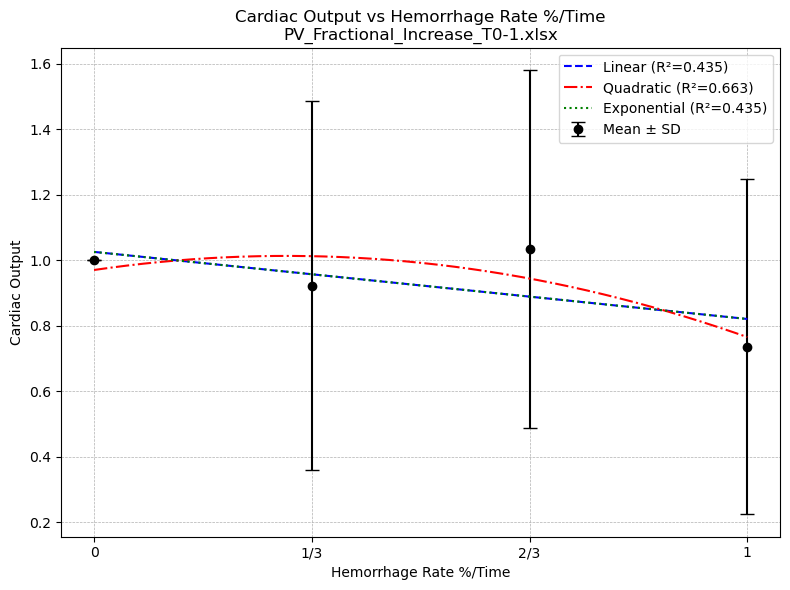


--- Cardiac Output ---
Linear fit:    y = -0.2048x + 1.0252     R² = 0.4352
Quadratic fit: y = -0.4972x² + 0.2924x + 0.9700     R² = 0.6632
Exponential fit: y = 589.0171 * exp(-0.0003x) + -587.9919     R² = 0.4352

=== Processing PV Performance.xlsx ===


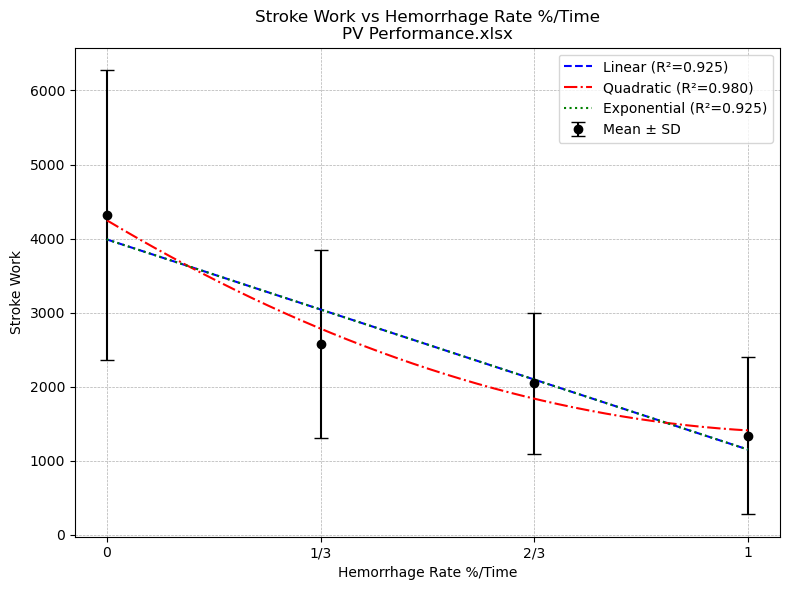


--- Stroke Work ---
Linear fit:    y = -2838.2785x + 3988.0948     R² = 0.9246
Quadratic fit: y = 2327.3070x² + -5165.5855x + 4246.6845     R² = 0.9798
Exponential fit: y = -8701568.3328 * exp(0.0003x) + 8705556.3538     R² = 0.9246


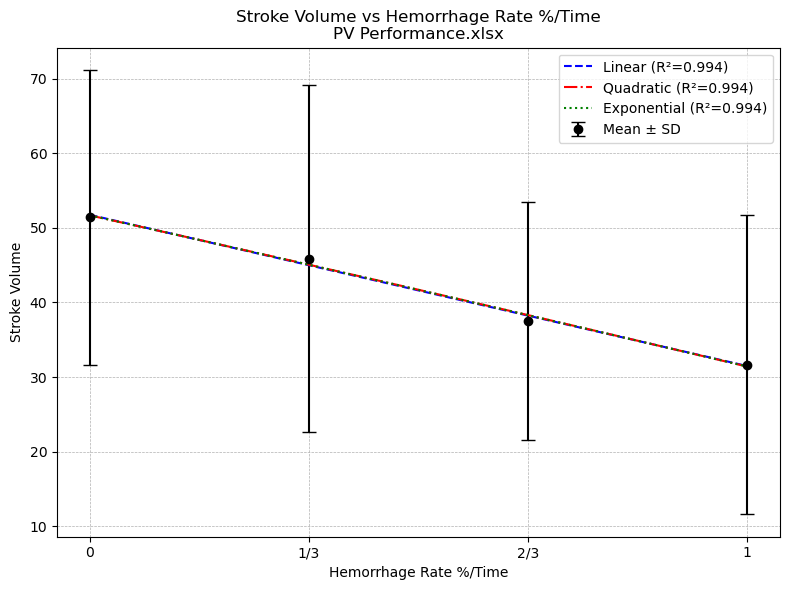


--- Stroke Volume ---
Linear fit:    y = -20.2596x + 51.7463     R² = 0.9940
Quadratic fit: y = -0.6408x² + -19.6188x + 51.6751     R² = 0.9941
Exponential fit: y = -334.9597 * exp(0.0587x) + 386.6401     R² = 0.9941


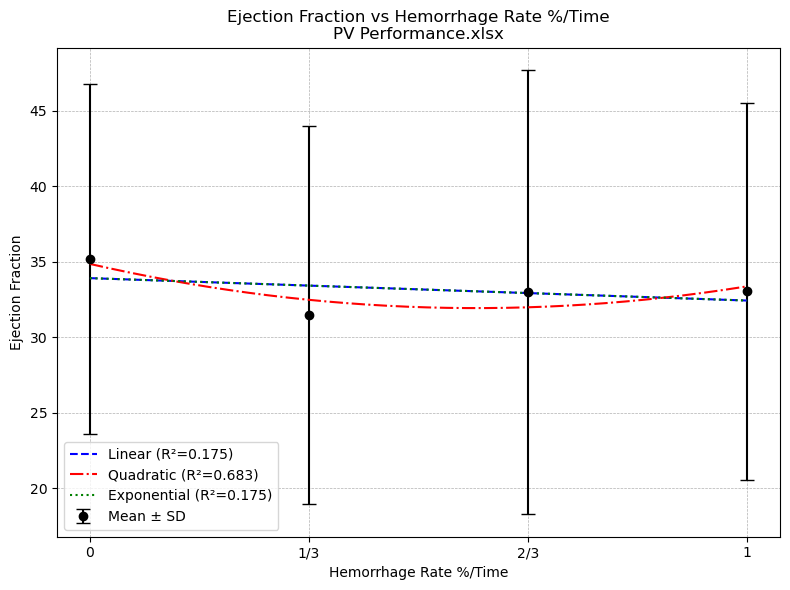


--- Ejection Fraction ---
Linear fit:    y = -1.4837x + 33.9250     R² = 0.1752
Quadratic fit: y = 8.4725x² + -9.9562x + 34.8664     R² = 0.6831
Exponential fit: y = -4396.0456 * exp(0.0003x) + 4429.9704     R² = 0.1752


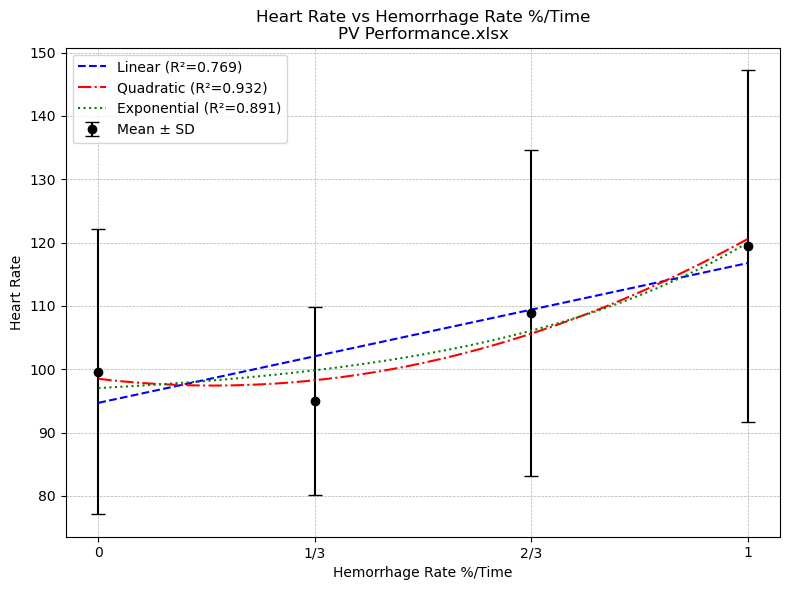


--- Heart Rate ---
Linear fit:    y = 22.0664x + 94.6920     R² = 0.7688
Quadratic fit: y = 34.1042x² + -12.0378x + 98.4813     R² = 0.9320
Exponential fit: y = 2.2977 * exp(2.3968x) + 94.7222     R² = 0.8912


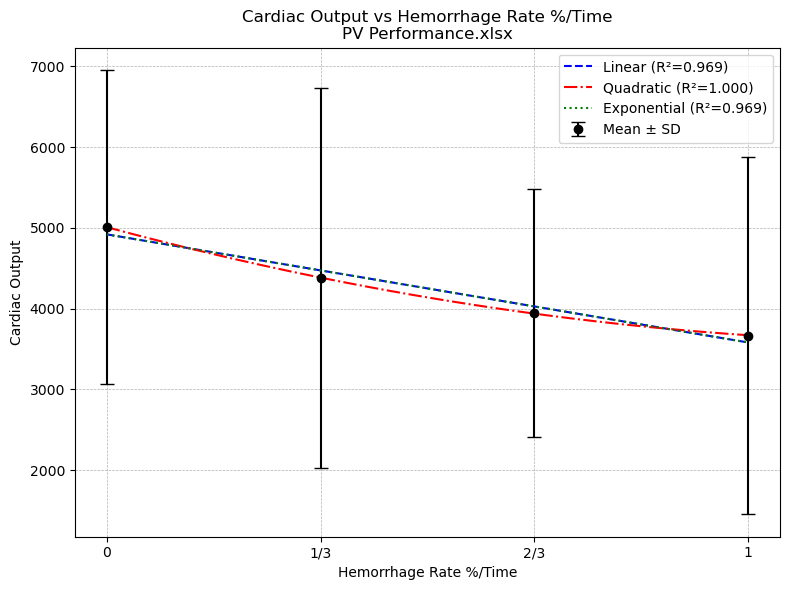


--- Cardiac Output ---
Linear fit:    y = -1338.2875x + 4919.6126     R² = 0.9687
Quadratic fit: y = 803.2542x² + -2141.5417x + 5008.8631     R² = 0.9998
Exponential fit: y = -3468797.3047 * exp(0.0004x) + 3473716.8776     R² = 0.9687


In [10]:
files = [
    'PV_Fractional_Increase_T0-1.xlsx',
    'PV Performance.xlsx',
]
analyze_files(files)


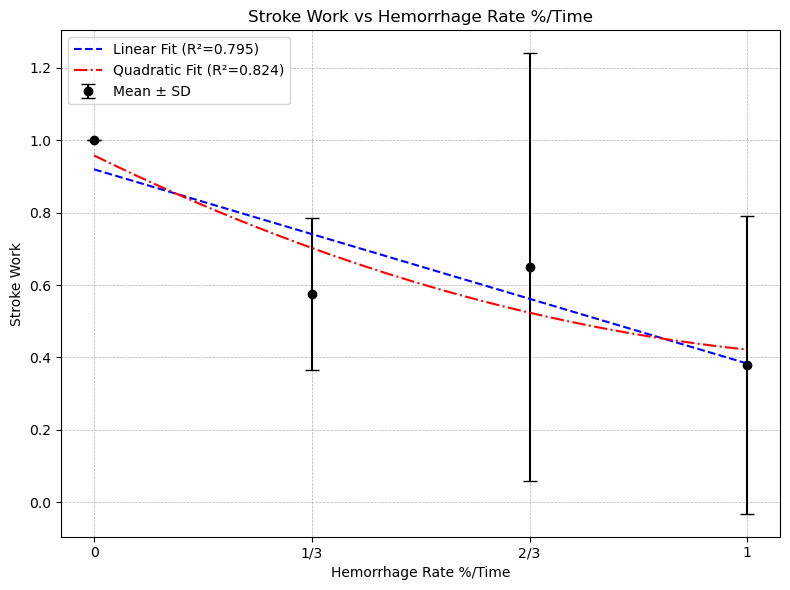

--- Stroke Work ---
Linear fit:    y = -0.5365x + 0.9196     R² = 0.7952
Quadratic fit: y = 0.3454x² + -0.8820x + 0.9580     R² = 0.8245



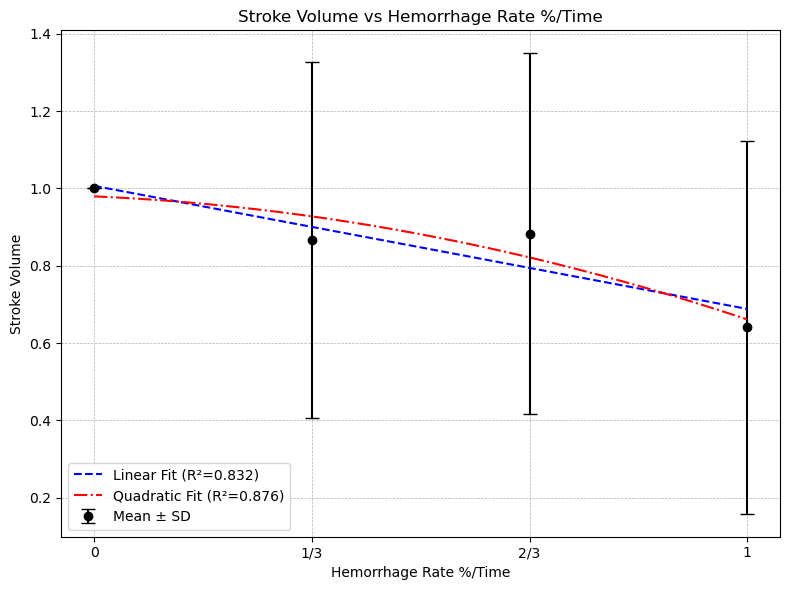

--- Stroke Volume ---
Linear fit:    y = -0.3185x + 1.0067     R² = 0.8325
Quadratic fit: y = -0.2447x² + -0.0738x + 0.9795     R² = 0.8762



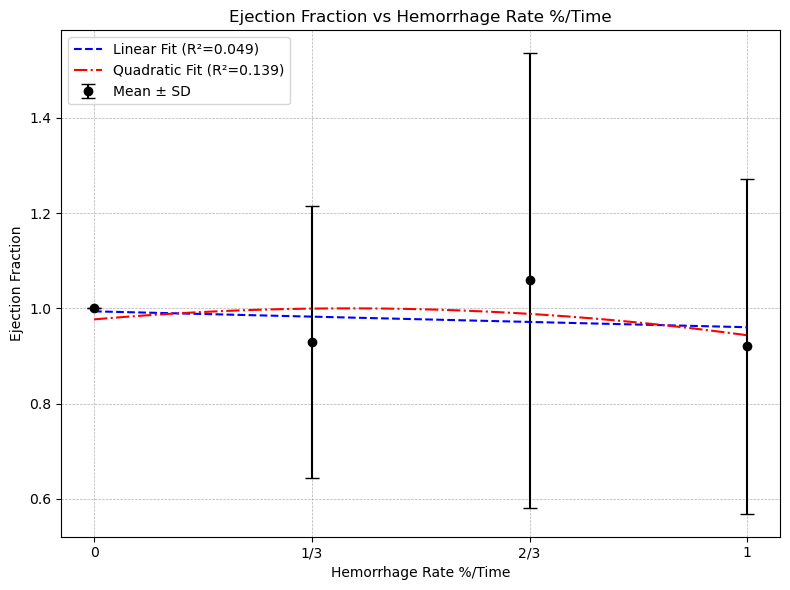

--- Ejection Fraction ---
Linear fit:    y = -0.0333x + 0.9935     R² = 0.0486
Quadratic fit: y = -0.1521x² + 0.1188x + 0.9766     R² = 0.1386



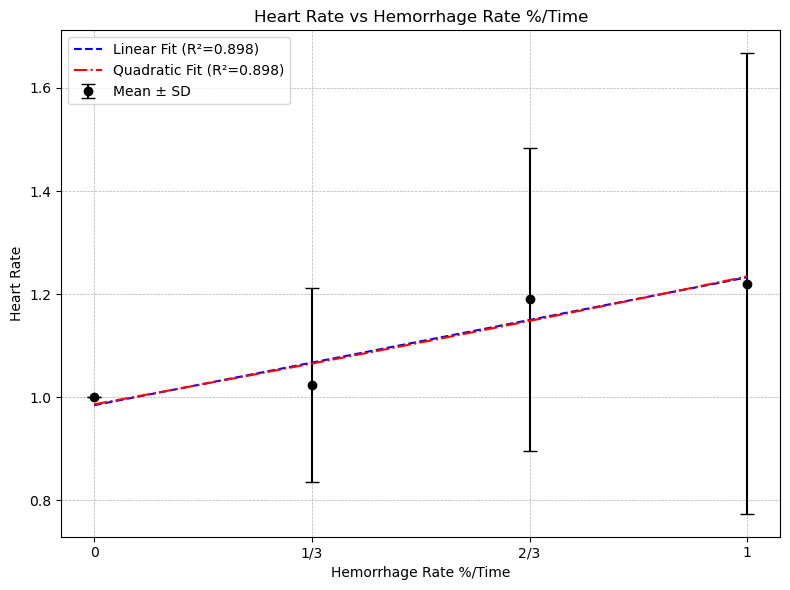

--- Heart Rate ---
Linear fit:    y = 0.2483x + 0.9842     R² = 0.8981
Quadratic fit: y = 0.0168x² + 0.2315x + 0.9861     R² = 0.8984



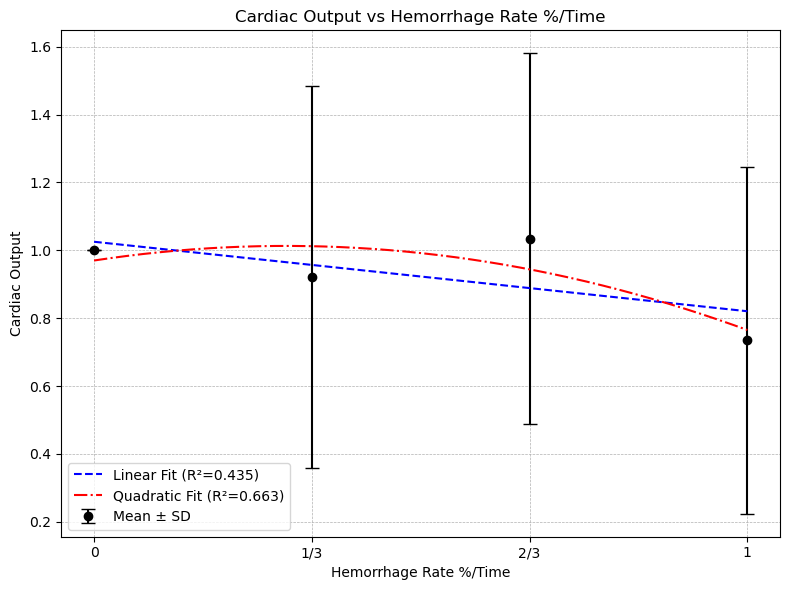

--- Cardiac Output ---
Linear fit:    y = -0.2048x + 1.0252     R² = 0.4352
Quadratic fit: y = -0.4972x² + 0.2924x + 0.9700     R² = 0.6632



In [2]:
file_path = 'PV_Fractional_Increase_T0-1.xlsx'
df = pd.read_excel(file_path)

# Define x and y columns
x_col = 'Hemorrhage Rate %/Time'
y_cols = [
    'Stroke Work',
    'Stroke Volume',
    'Ejection Fraction',
    'Heart Rate',
    'Cardiac Output'
]

# Normalize x-axis values to 0–1 range
x_min = df[x_col].min()
x_max = df[x_col].max()
df['Normalized X'] = (df[x_col] - x_min) / (x_max - x_min)

# Group by normalized x and calculate mean/std
grouped = df.groupby('Normalized X')

# Define custom tick positions and labels
tick_positions = [0.0, 1/3, 2/3, 1.0]
# tick_labels = ['0', '1/3', '2/3', '3/3']
tick_labels = ['0', '1/3', '2/3', '1']

# Loop through each y-axis column
for y_col in y_cols:
    if y_col in df.columns:
        means = grouped[y_col].mean()
        stds = grouped[y_col].std()
        x_vals = means.index

        # Drop NaNs
        valid = ~(means.isna() | stds.isna())
        x_clean = x_vals[valid]
        y_mean = means[valid]
        y_std = stds[valid]

        # Fit models on normalized x
        linear_coeffs = np.polyfit(x_clean, y_mean, 1)
        quad_coeffs = np.polyfit(x_clean, y_mean, 2)

        y_linear_pred = np.polyval(linear_coeffs, x_clean)
        y_quad_pred = np.polyval(quad_coeffs, x_clean)

        ss_tot = np.sum((y_mean - np.mean(y_mean)) ** 2)
        r2_linear = 1 - np.sum((y_mean - y_linear_pred) ** 2) / ss_tot
        r2_quad = 1 - np.sum((y_mean - y_quad_pred) ** 2) / ss_tot

        # Smooth x for fit lines
        x_fit = np.linspace(0, 1, 200)
        y_linear_fit = np.polyval(linear_coeffs, x_fit)
        y_quad_fit = np.polyval(quad_coeffs, x_fit)

        # Plot
        plt.figure(figsize=(8, 6))
        plt.errorbar(x_clean, y_mean, yerr=y_std, fmt='o', label='Mean ± SD', color='black', capsize=5)
        plt.plot(x_fit, y_linear_fit, label=f'Linear Fit (R²={r2_linear:.3f})', linestyle='--', color='blue')
        plt.plot(x_fit, y_quad_fit, label=f'Quadratic Fit (R²={r2_quad:.3f})', linestyle='-.', color='red')

        plt.xlabel('Hemorrhage Rate %/Time')
        plt.ylabel(y_col)
        plt.title(f'{y_col} vs Hemorrhage Rate %/Time')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.xticks(tick_positions, tick_labels)
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Print equations and R²
        print(f"--- {y_col} ---")
        print(f"Linear fit:    y = {linear_coeffs[0]:.4f}x + {linear_coeffs[1]:.4f}     R² = {r2_linear:.4f}")
        print(f"Quadratic fit: y = {quad_coeffs[0]:.4f}x² + {quad_coeffs[1]:.4f}x + {quad_coeffs[2]:.4f}     R² = {r2_quad:.4f}")
        print()

    else:
        print(f"Column '{y_col}' not found in the data.")


In [3]:
print('Done with the code being run.')

Done with the code being run.


In [4]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np
# from scipy.optimize import curve_fit

# def analyze_and_plot(file_path, x_col, y_cols):
#     """
#     Analyze and plot mean/median trends with linear, quadratic, and exponential fits,
#     alongside scatter + boxplot visualization.

#     Parameters:
#     -----------
#     file_path : str
#         Path to Excel file
#     x_col : str
#         Column name for independent variable
#     y_cols : list
#         List of dependent variable column names
#     """

#     # Load dataset
#     df = pd.read_excel(file_path)

#     # Normalize x-axis values
#     x_min, x_max = df[x_col].min(), df[x_col].max()
#     df['Normalized X'] = (df[x_col] - x_min) / (x_max - x_min)

#     # Define custom ticks
#     tick_positions = [0.0, 1/3, 2/3, 1.0]
#     tick_labels = ['0', '1/3', '2/3', '1']

#     # Define exponential function
#     def exp_func(x, a, b, c):
#         return a * np.exp(b * x) + c

#     # Loop through each y-col
#     for y_col in y_cols:
#         if y_col not in df.columns:
#             print(f"Column '{y_col}' not found in the data.")
#             continue

#         # Group by normalized x
#         grouped = df.groupby('Normalized X')
#         means = grouped[y_col].mean()
#         medians = grouped[y_col].median()
#         stds = grouped[y_col].std()

#         x_vals = means.index

#         # Drop NaNs
#         valid = ~(means.isna() | stds.isna() | medians.isna())
#         x_clean = x_vals[valid]
#         y_mean = means[valid]
#         y_median = medians[valid]
#         y_std = stds[valid]

#         # --- Function to fit and plot (mean or median separately) ---
#         def fit_and_plot(y_data, label_color, label_name):
#             fits = {}

#             # Linear
#             linear_coeffs = np.polyfit(x_clean, y_data, 1)
#             y_linear_pred = np.polyval(linear_coeffs, x_clean)

#             # Quadratic
#             quad_coeffs = np.polyfit(x_clean, y_data, 2)
#             y_quad_pred = np.polyval(quad_coeffs, x_clean)

#             # Exponential
#             try:
#                 popt, _ = curve_fit(exp_func, x_clean, y_data, maxfev=10000)
#                 y_exp_pred = exp_func(x_clean, *popt)
#                 r2_exp = 1 - np.sum((y_data - y_exp_pred) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)
#             except RuntimeError:
#                 popt = [np.nan, np.nan, np.nan]
#                 r2_exp = np.nan

#             # R²
#             ss_tot = np.sum((y_data - np.mean(y_data)) ** 2)
#             r2_linear = 1 - np.sum((y_data - y_linear_pred) ** 2) / ss_tot
#             r2_quad = 1 - np.sum((y_data - y_quad_pred) ** 2) / ss_tot

#             fits = {
#                 "linear": (linear_coeffs, r2_linear),
#                 "quadratic": (quad_coeffs, r2_quad),
#                 "exponential": (popt, r2_exp)
#             }

#             # Plotting
#             x_fit = np.linspace(0, 1, 200)
#             plt.figure(figsize=(9, 7))

#             # Boxplot with matplotlib for transparency
#             data_by_bin = [df[df["Normalized X"] == xv][y_col].dropna().values for xv in sorted(df["Normalized X"].unique())]
#             plt.boxplot(data_by_bin, positions=sorted(df["Normalized X"].unique()), widths=0.03,
#                         patch_artist=True, boxprops=dict(facecolor="lightgray", alpha=0.4))

#             # Scatter raw data on top
#             plt.scatter(
#                 df['Normalized X'], df[y_col],
#                 alpha=0.6, s=25, color="black", label="Raw Data", zorder=3
#             )

#             # Fits
#             coeffs_lin, r2_lin = fits["linear"]
#             coeffs_quad, r2_quad = fits["quadratic"]
#             coeffs_exp, r2_exp = fits["exponential"]

#             plt.plot(x_fit, np.polyval(coeffs_lin, x_fit),
#                      linestyle="--", color=label_color,
#                      label=f"Linear (R²={r2_lin:.3f})", zorder=4)

#             plt.plot(x_fit, np.polyval(coeffs_quad, x_fit),
#                      linestyle="-.", color=label_color,
#                      label=f"Quadratic (R²={r2_quad:.3f})", zorder=4)

#             if not np.isnan(coeffs_exp[0]):
#                 plt.plot(x_fit, exp_func(x_fit, *coeffs_exp),
#                          linestyle=":", color=label_color,
#                          label=f"Exp (R²={r2_exp:.3f})", zorder=4)

#             # Labels & Formatting
#             plt.xlabel('Hemorrhage Rate %/Time (Normalized)')
#             plt.ylabel(y_col)
#             plt.title(f'{y_col} vs Hemorrhage Rate %/Time ({label_name})')
#             plt.grid(True, linestyle="--", alpha=0.6)
#             plt.xticks(tick_positions, tick_labels)
#             plt.legend()
#             plt.tight_layout()
#             plt.show()

#             # Print equations
#             print(f"--- {y_col} ({label_name}) ---")
#             print(f"Linear:    y = {coeffs_lin[0]:.4f}x + {coeffs_lin[1]:.4f}     R² = {r2_lin:.4f}")
#             print(f"Quadratic: y = {coeffs_quad[0]:.4f}x² + {coeffs_quad[1]:.4f}x + {coeffs_quad[2]:.4f}     R² = {r2_quad:.4f}")
#             if not np.isnan(coeffs_exp[0]):
#                 print(f"Exp:       y = {coeffs_exp[0]:.4f} * exp({coeffs_exp[1]:.4f}x) + {coeffs_exp[2]:.4f}     R² = {r2_exp:.4f}")
#             print()

#         # --- Call separately for mean and median ---
#         fit_and_plot(y_mean, "blue", "Mean")
#         fit_and_plot(y_median, "red", "Median")


# # Example run
# file_path = 'PV_Fractional_Increase_T0-1.xlsx'
# x_col = 'Hemorrhage Rate %/Time'
# y_cols = ['Stroke Work', 'Stroke Volume', 'Ejection Fraction', 'Heart Rate', 'Cardiac Output']

# analyze_and_plot(file_path, x_col, y_cols)


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import plotly.express as px

def analyze_and_plot(file_path, x_col, y_cols):
    """
    Analyze and plot mean/median trends with linear, quadratic, and exponential fits,
    alongside scatter + boxplot visualization. Also saves interactive scatter plots with Plotly.
    """

    # Load dataset
    df = pd.read_excel(file_path)

    # Normalize x-axis values
    x_min, x_max = df[x_col].min(), df[x_col].max()
    df['Normalized X'] = (df[x_col] - x_min) / (x_max - x_min)

    # Define custom ticks
    tick_positions = [0.0, 1/3, 2/3, 1.0]
    tick_labels = ['0', '1/3', '2/3', '1']

    # Define exponential function
    def exp_func(x, a, b, c):
        return a * np.exp(b * x) + c

    # Loop through each y-col
    for y_col in y_cols:
        if y_col not in df.columns:
            print(f"Column '{y_col}' not found in the data.")
            continue

        # Group by normalized x
        grouped = df.groupby('Normalized X')
        means = grouped[y_col].mean()
        medians = grouped[y_col].median()
        stds = grouped[y_col].std()

        x_vals = means.index

        # Drop NaNs
        valid = ~(means.isna() | stds.isna() | medians.isna())
        x_clean = x_vals[valid]
        y_mean = means[valid]
        y_median = medians[valid]
        y_std = stds[valid]

        # --- Function to fit and plot (mean or median separately) ---
        def fit_and_plot(y_data, label_color, label_name):
            # Linear
            linear_coeffs = np.polyfit(x_clean, y_data, 1)
            y_linear_pred = np.polyval(linear_coeffs, x_clean)

            # Quadratic
            quad_coeffs = np.polyfit(x_clean, y_data, 2)
            y_quad_pred = np.polyval(quad_coeffs, x_clean)

            # Exponential
            try:
                popt, _ = curve_fit(exp_func, x_clean, y_data, maxfev=10000)
                y_exp_pred = exp_func(x_clean, *popt)
                r2_exp = 1 - np.sum((y_data - y_exp_pred) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)
            except RuntimeError:
                popt = [np.nan, np.nan, np.nan]
                r2_exp = np.nan

            # R²
            ss_tot = np.sum((y_data - np.mean(y_data)) ** 2)
            r2_linear = 1 - np.sum((y_data - y_linear_pred) ** 2) / ss_tot
            r2_quad = 1 - np.sum((y_data - y_quad_pred) ** 2) / ss_tot

            # Plotting
            x_fit = np.linspace(0, 1, 200)
            plt.figure(figsize=(9, 7))

            # Boxplot with matplotlib for transparency
            data_by_bin = [df[df["Normalized X"] == xv][y_col].dropna().values for xv in sorted(df["Normalized X"].unique())]
            plt.boxplot(data_by_bin, positions=sorted(df["Normalized X"].unique()), widths=0.03,
                        patch_artist=True, boxprops=dict(facecolor="lightgray", alpha=0.4))

            # Scatter raw data on top
            plt.scatter(
                df['Normalized X'], df[y_col],
                alpha=0.6, s=25, color="black", label="Raw Data", zorder=3
            )

            # Fits
            plt.plot(x_fit, np.polyval(linear_coeffs, x_fit),
                     linestyle="--", color=label_color,
                     label=f"Linear (R²={r2_linear:.3f})", zorder=4)

            plt.plot(x_fit, np.polyval(quad_coeffs, x_fit),
                     linestyle="-.", color=label_color,
                     label=f"Quadratic (R²={r2_quad:.3f})", zorder=4)

            if not np.isnan(popt[0]):
                plt.plot(x_fit, exp_func(x_fit, *popt),
                         linestyle=":", color=label_color,
                         label=f"Exp (R²={r2_exp:.3f})", zorder=4)

            # Labels & Formatting
            plt.xlabel('Hemorrhage Rate %/Time (Normalized)')
            plt.ylabel(y_col)
            plt.title(f'{y_col} vs Hemorrhage Rate %/Time ({label_name})')
            plt.grid(True, linestyle="--", alpha=0.6)
            plt.xticks(tick_positions, tick_labels)
            plt.xlim(-0.05, 1.05)  # tighten x-axis spacing
            plt.legend()
            plt.tight_layout()
            plt.show()

            # Print equations
            print(f"--- {y_col} ({label_name}) ---")
            print(f"Linear:    y = {linear_coeffs[0]:.4f}x + {linear_coeffs[1]:.4f}     R² = {r2_linear:.4f}")
            print(f"Quadratic: y = {quad_coeffs[0]:.4f}x² + {quad_coeffs[1]:.4f}x + {quad_coeffs[2]:.4f}     R² = {r2_quad:.4f}")
            if not np.isnan(popt[0]):
                print(f"Exp:       y = {popt[0]:.4f} * exp({popt[1]:.4f}x) + {popt[2]:.4f}     R² = {r2_exp:.4f}")
            print()

        # --- Call separately for mean and median ---
        fit_and_plot(y_mean, "blue", "Mean")
        fit_and_plot(y_median, "red", "Median")

        # --- Plotly scatter export ---
        if "Parent Folder" in df.columns:
            fig = px.scatter(
                df, x="Normalized X", y=y_col,
                hover_data=["Parent Folder"],
                title=f"{y_col} Scatter Plot (Interactive)"
            )
            fig.update_traces(marker=dict(size=7, opacity=0.6))
            fig.write_html(f"{y_col}_scatter.html")
            fig.write_image(f"{y_col}_scatter.png")
            print(f"Saved Plotly scatter plots for {y_col} → HTML + PNG")


In [6]:
x_col = 'Hemorrhage Rate %/Time'
y_cols = ['Stroke Work', 'Stroke Volume', 'Ejection Fraction', 'Heart Rate', 'Cardiac Output']

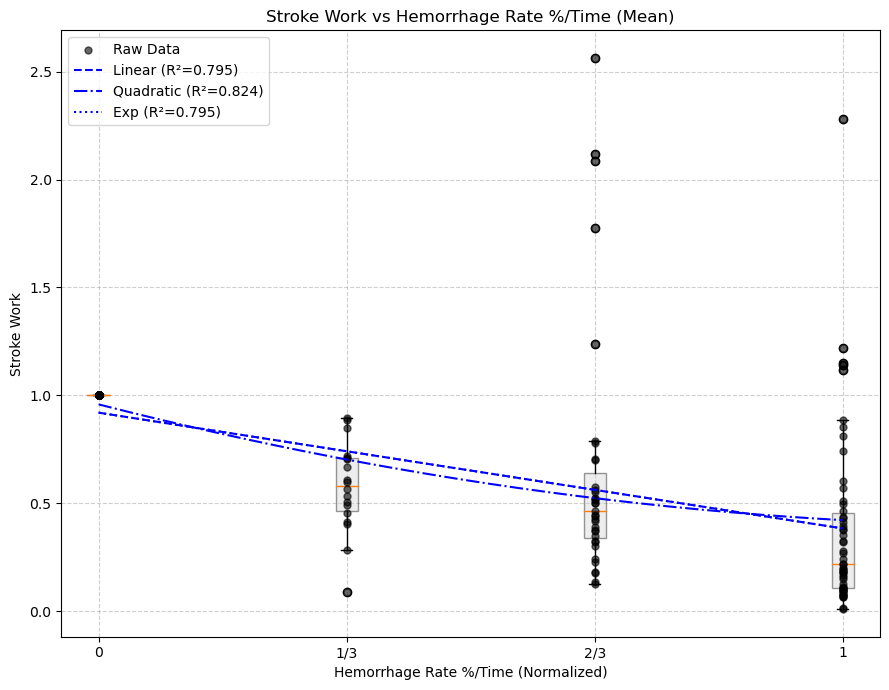

--- Stroke Work (Mean) ---
Linear:    y = -0.5365x + 0.9196     R² = 0.7952
Quadratic: y = 0.3454x² + -0.8820x + 0.9580     R² = 0.8245
Exp:       y = -1150.7559 * exp(0.0005x) + 1151.6755     R² = 0.7952



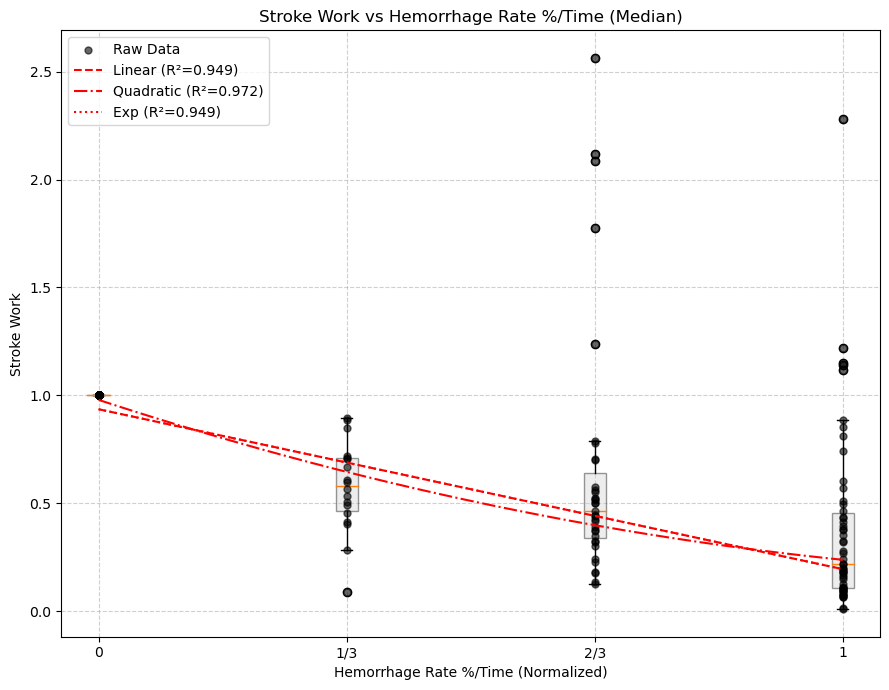

--- Stroke Work (Median) ---
Linear:    y = -0.7411x + 0.9355     R² = 0.9487
Quadratic: y = 0.3897x² + -1.1308x + 0.9788     R² = 0.9720
Exp:       y = -2027.9107 * exp(0.0004x) + 2028.8462     R² = 0.9487

Saved Plotly scatter plots for Stroke Work → HTML + PNG


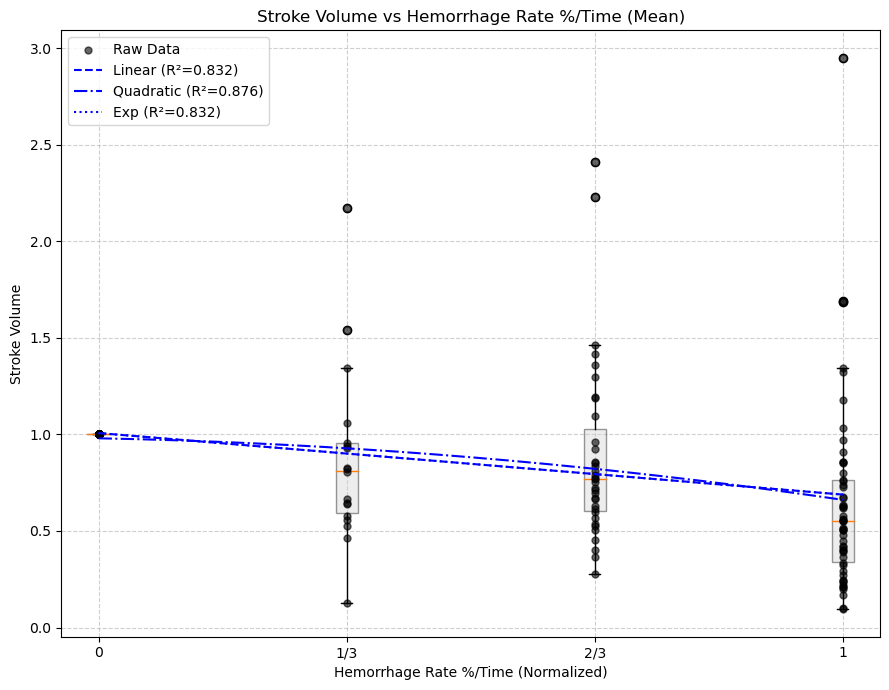

--- Stroke Volume (Mean) ---
Linear:    y = -0.3185x + 1.0067     R² = 0.8325
Quadratic: y = -0.2447x² + -0.0738x + 0.9795     R² = 0.8762
Exp:       y = 998.2900 * exp(-0.0003x) + -997.2833     R² = 0.8325



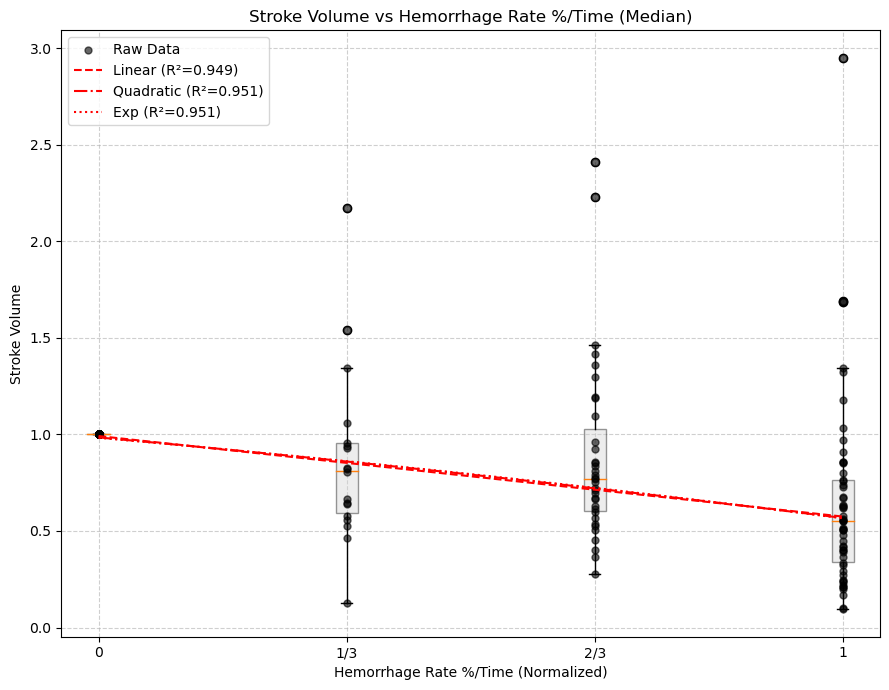

--- Stroke Volume (Median) ---
Linear:    y = -0.4169x + 0.9913     R² = 0.9488
Quadratic: y = -0.0639x² + -0.3530x + 0.9842     R² = 0.9507
Exp:       y = -0.8545 * exp(0.3974x) + 1.8367     R² = 0.9513

Saved Plotly scatter plots for Stroke Volume → HTML + PNG


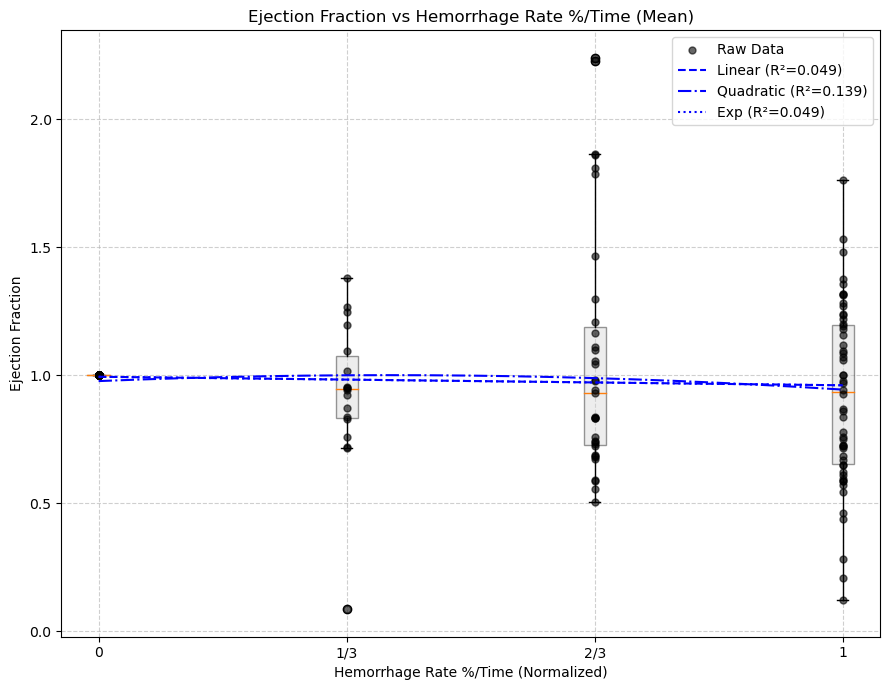

--- Ejection Fraction (Mean) ---
Linear:    y = -0.0333x + 0.9935     R² = 0.0486
Quadratic: y = -0.1521x² + 0.1188x + 0.9766     R² = 0.1386
Exp:       y = 76.3124 * exp(-0.0004x) + -75.3189     R² = 0.0486



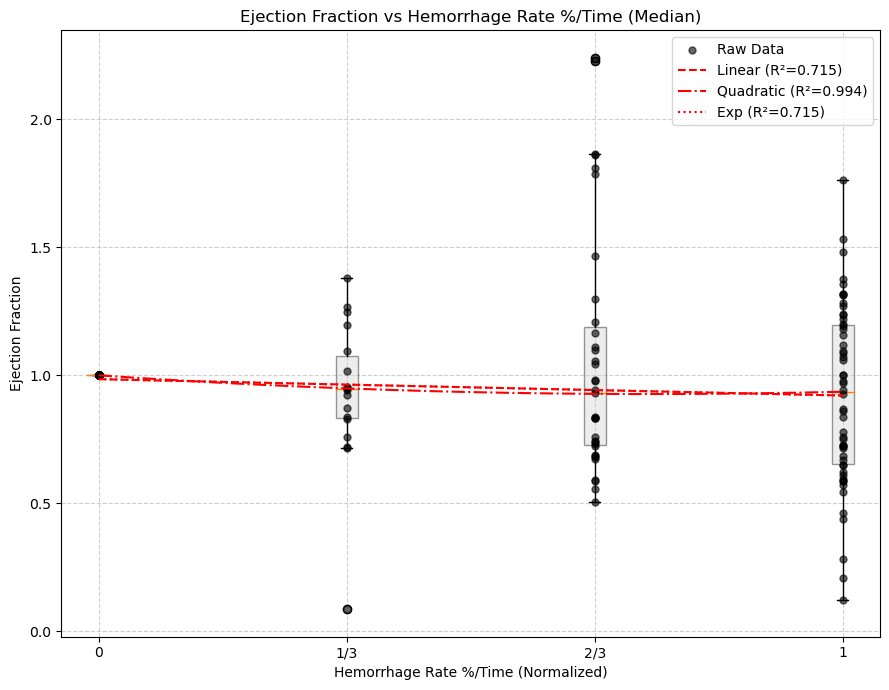

--- Ejection Fraction (Median) ---
Linear:    y = -0.0639x + 0.9842     R² = 0.7154
Quadratic: y = 0.1339x² + -0.1978x + 0.9990     R² = 0.9943
Exp:       y = -279.1584 * exp(0.0002x) + 280.1426     R² = 0.7153

Saved Plotly scatter plots for Ejection Fraction → HTML + PNG


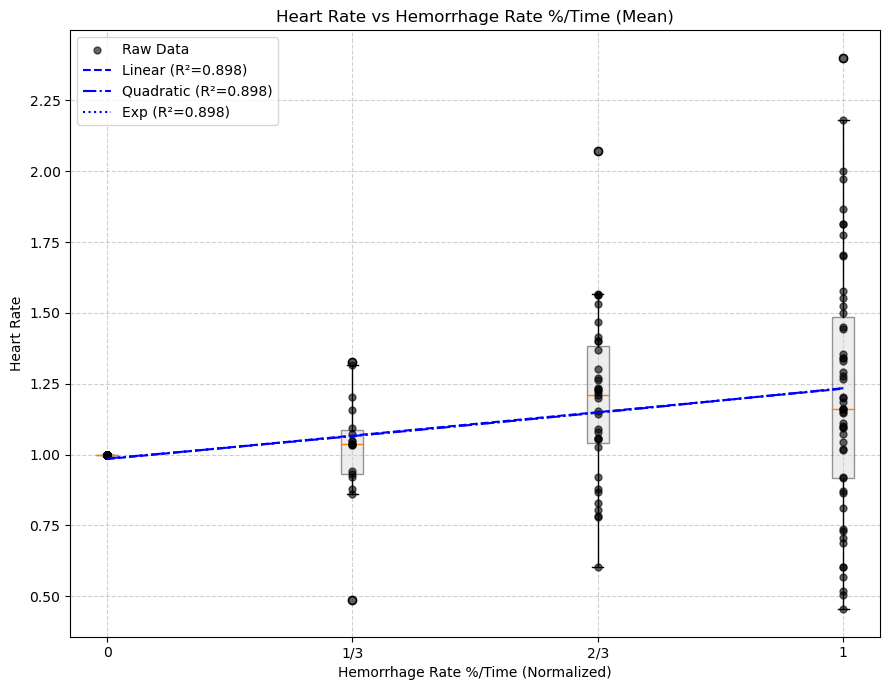

--- Heart Rate (Mean) ---
Linear:    y = 0.2483x + 0.9842     R² = 0.8981
Quadratic: y = 0.0168x² + 0.2315x + 0.9861     R² = 0.8984
Exp:       y = 2.3339 * exp(0.1011x) + -1.3483     R² = 0.8984



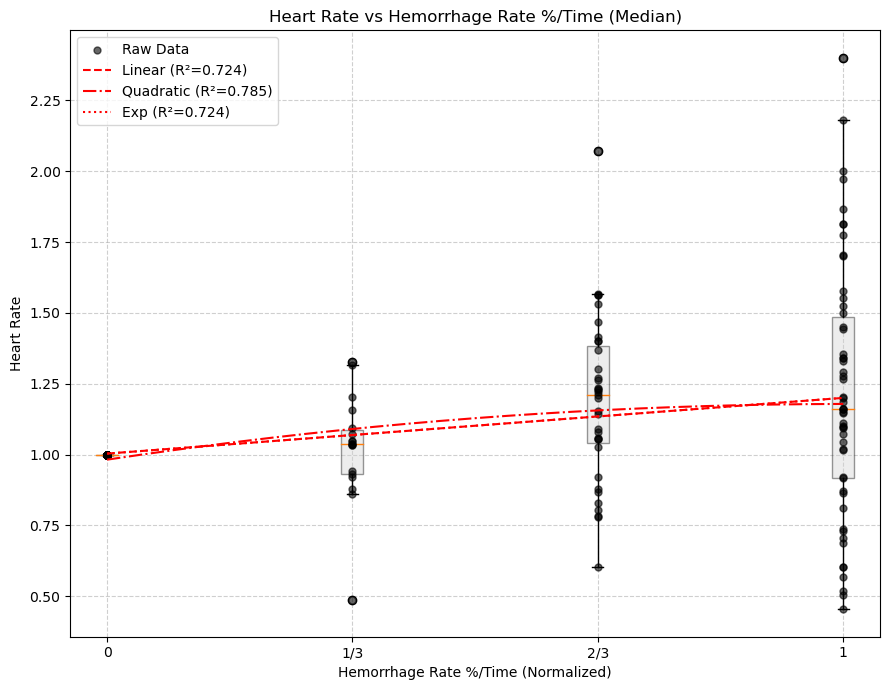

--- Heart Rate (Median) ---
Linear:    y = 0.1966x + 1.0035     R² = 0.7237
Quadratic: y = -0.1924x² + 0.3890x + 0.9822     R² = 0.7853
Exp:       y = 454.1793 * exp(0.0004x) + -453.1758     R² = 0.7237

Saved Plotly scatter plots for Heart Rate → HTML + PNG


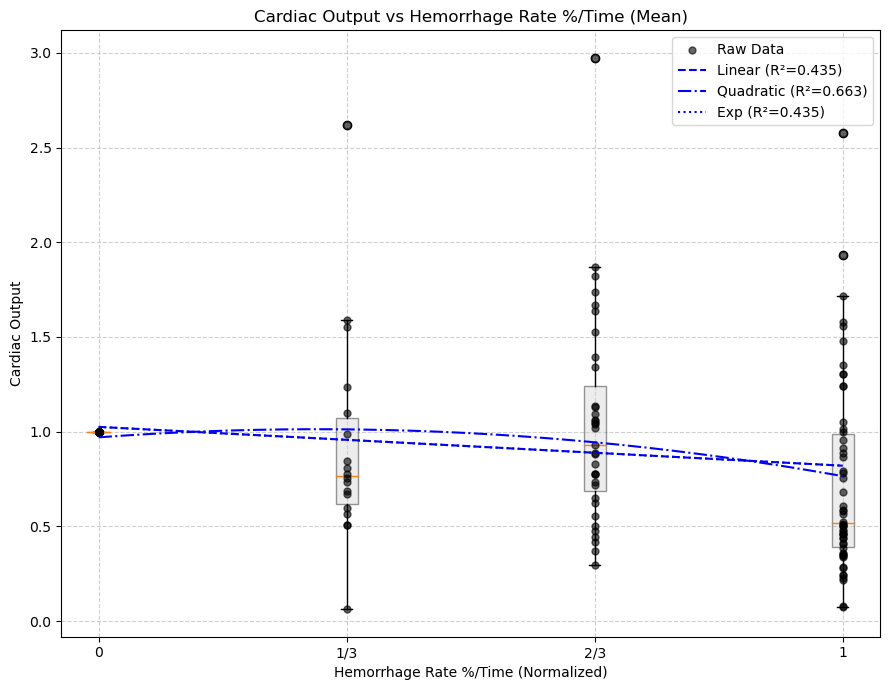

--- Cardiac Output (Mean) ---
Linear:    y = -0.2048x + 1.0252     R² = 0.4352
Quadratic: y = -0.4972x² + 0.2924x + 0.9700     R² = 0.6632
Exp:       y = 589.0171 * exp(-0.0003x) + -587.9919     R² = 0.4352



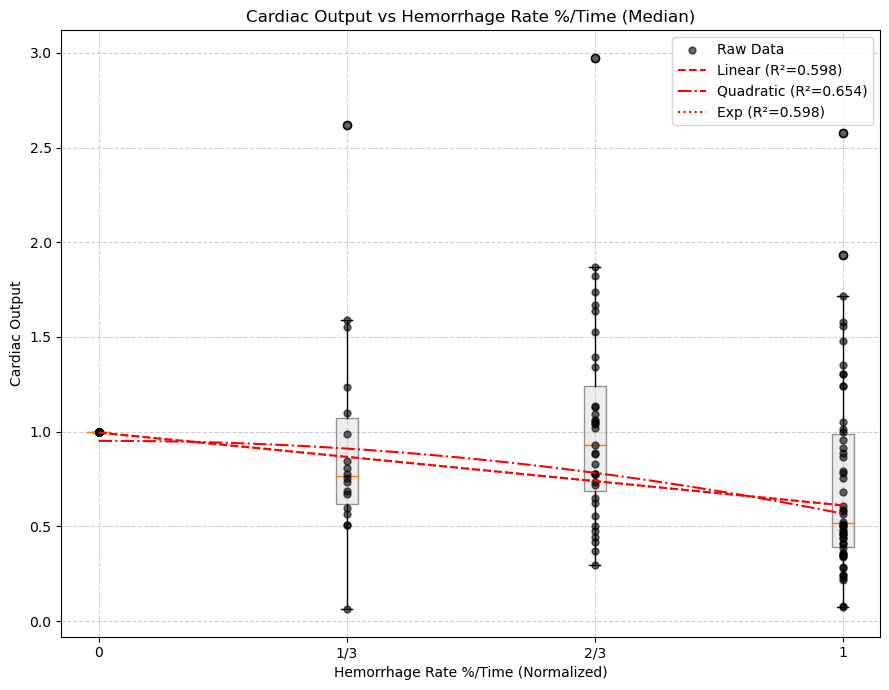

--- Cardiac Output (Median) ---
Linear:    y = -0.3841x + 0.9951     R² = 0.5982
Quadratic: y = -0.3940x² + 0.0099x + 0.9513     R² = 0.6542
Exp:       y = 737.2734 * exp(-0.0005x) + -736.2783     R² = 0.5982

Saved Plotly scatter plots for Cardiac Output → HTML + PNG


In [7]:
analyze_and_plot('PV_Fractional_Increase_T0-1.xlsx', x_col, y_cols)

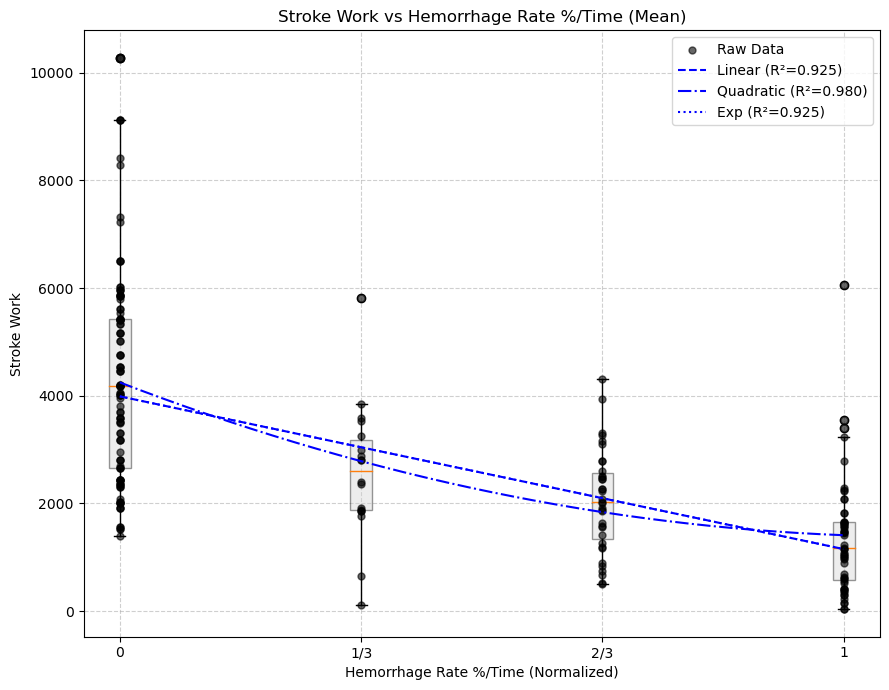

--- Stroke Work (Mean) ---
Linear:    y = -2838.2785x + 3988.0948     R² = 0.9246
Quadratic: y = 2327.3070x² + -5165.5855x + 4246.6845     R² = 0.9798
Exp:       y = -8701568.3328 * exp(0.0003x) + 8705556.3538     R² = 0.9246



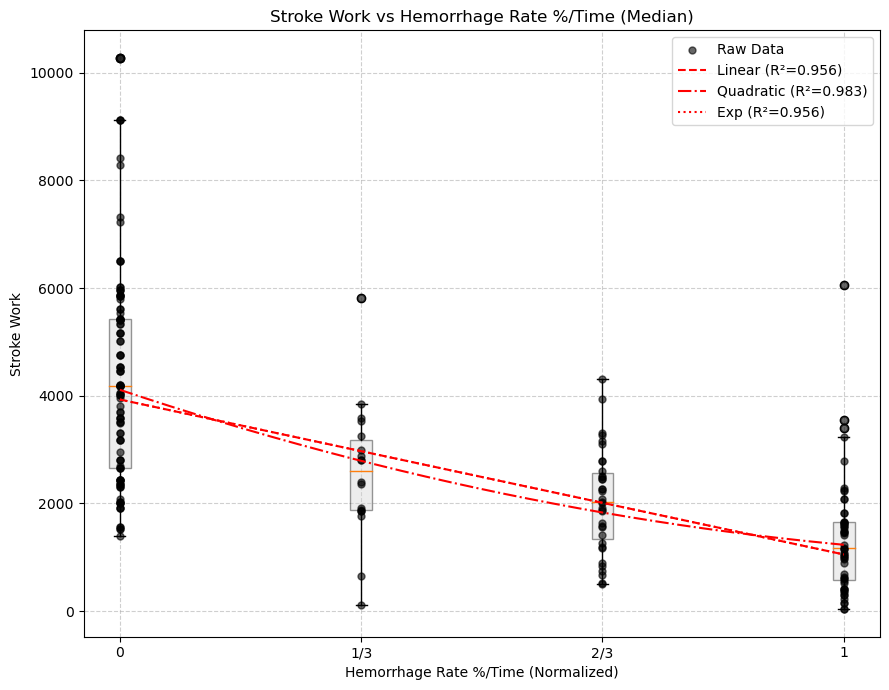

--- Stroke Work (Median) ---
Linear:    y = -2878.8272x + 3929.4710     R² = 0.9563
Quadratic: y = 1621.4507x² + -4500.2779x + 4109.6322     R² = 0.9833
Exp:       y = -8424464.0842 * exp(0.0003x) + 8428393.4824     R² = 0.9563

Saved Plotly scatter plots for Stroke Work → HTML + PNG


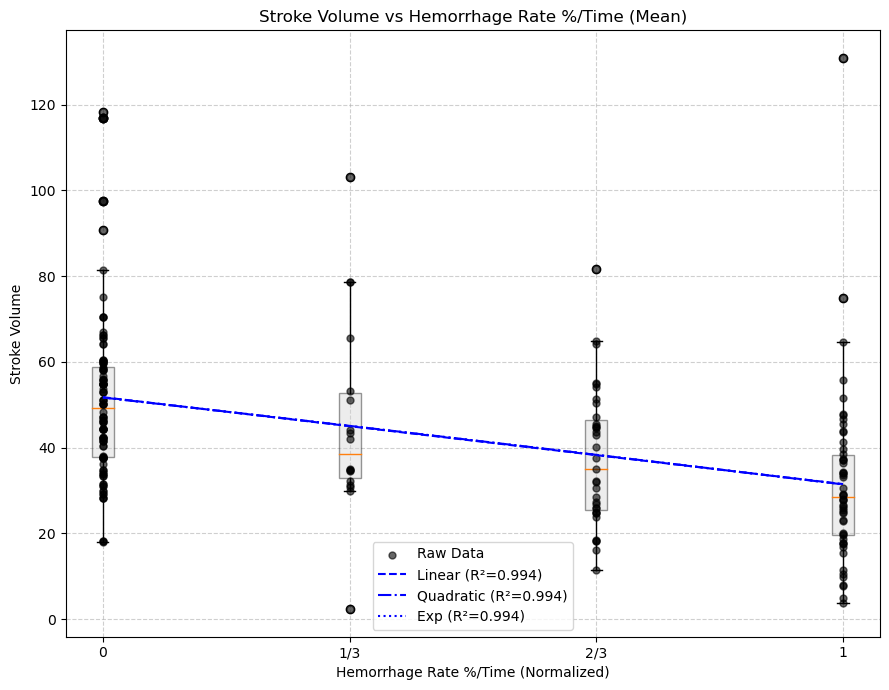

--- Stroke Volume (Mean) ---
Linear:    y = -20.2596x + 51.7463     R² = 0.9940
Quadratic: y = -0.6408x² + -19.6188x + 51.6751     R² = 0.9941
Exp:       y = -334.9597 * exp(0.0587x) + 386.6401     R² = 0.9941



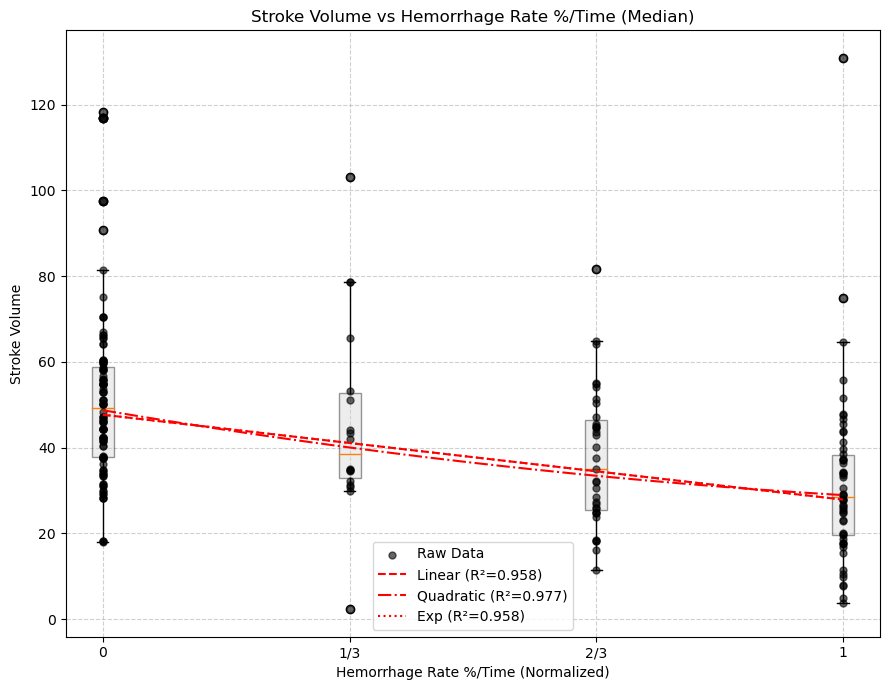

--- Stroke Volume (Median) ---
Linear:    y = -19.7950x + 47.6623     R² = 0.9582
Quadratic: y = 9.4093x² + -29.2043x + 48.7078     R² = 0.9775
Exp:       y = -66633.0947 * exp(0.0003x) + 66680.7567     R² = 0.9582

Saved Plotly scatter plots for Stroke Volume → HTML + PNG


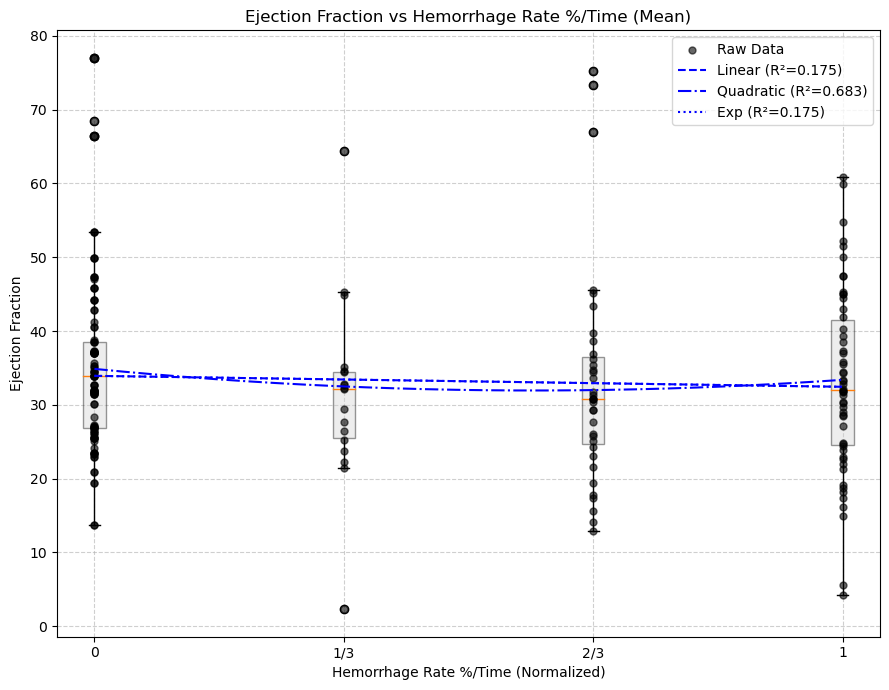

--- Ejection Fraction (Mean) ---
Linear:    y = -1.4837x + 33.9250     R² = 0.1752
Quadratic: y = 8.4725x² + -9.9562x + 34.8664     R² = 0.6831
Exp:       y = -4396.0456 * exp(0.0003x) + 4429.9704     R² = 0.1752



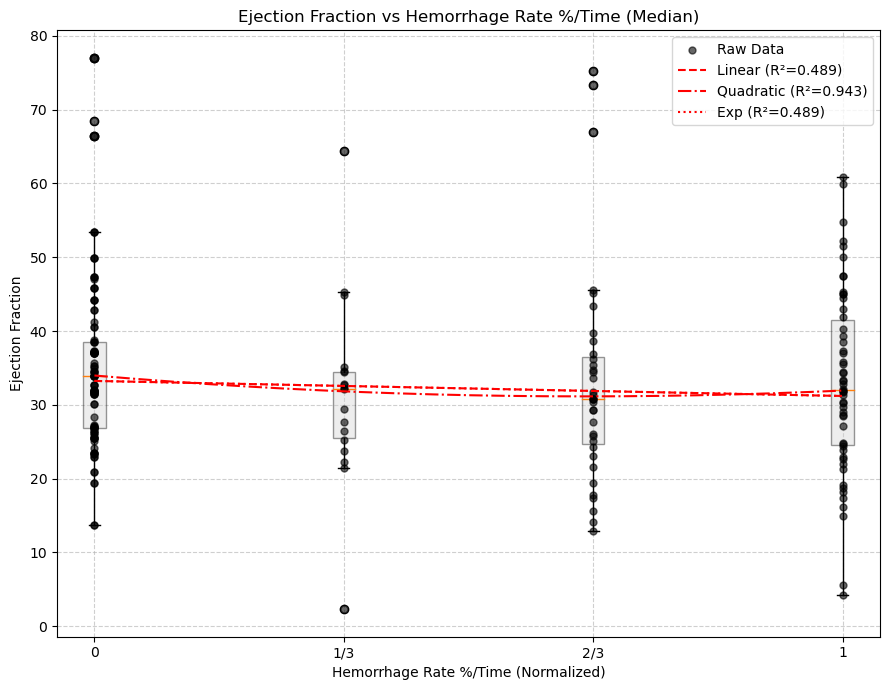

--- Ejection Fraction (Median) ---
Linear:    y = -2.0414x + 33.2378     R² = 0.4891
Quadratic: y = 6.5934x² + -8.6348x + 33.9704     R² = 0.9425
Exp:       y = -7516.2002 * exp(0.0003x) + 7549.4379     R² = 0.4890

Saved Plotly scatter plots for Ejection Fraction → HTML + PNG


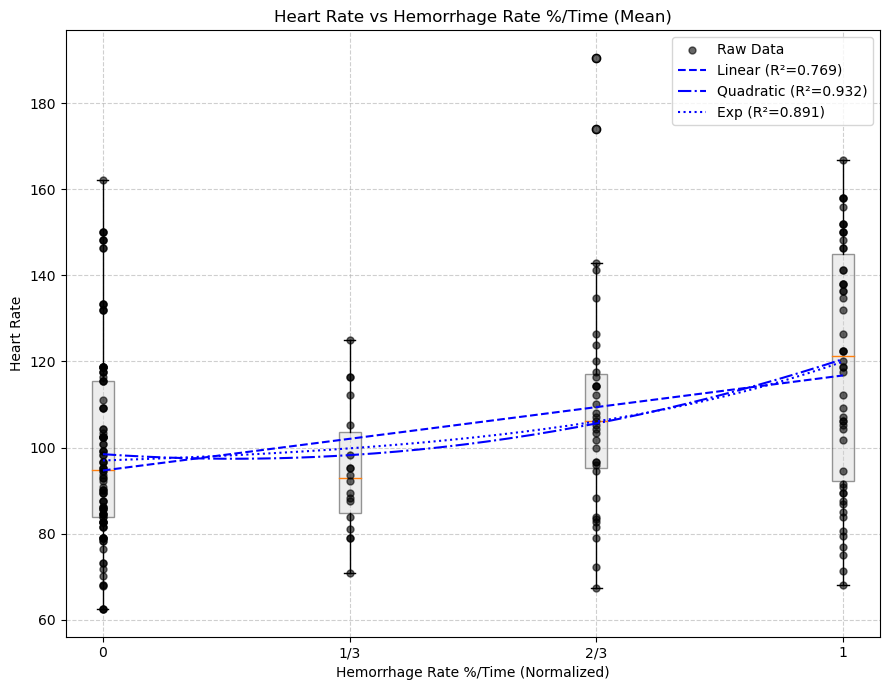

--- Heart Rate (Mean) ---
Linear:    y = 22.0664x + 94.6920     R² = 0.7688
Quadratic: y = 34.1042x² + -12.0378x + 98.4813     R² = 0.9320
Exp:       y = 2.2977 * exp(2.3968x) + 94.7222     R² = 0.8912



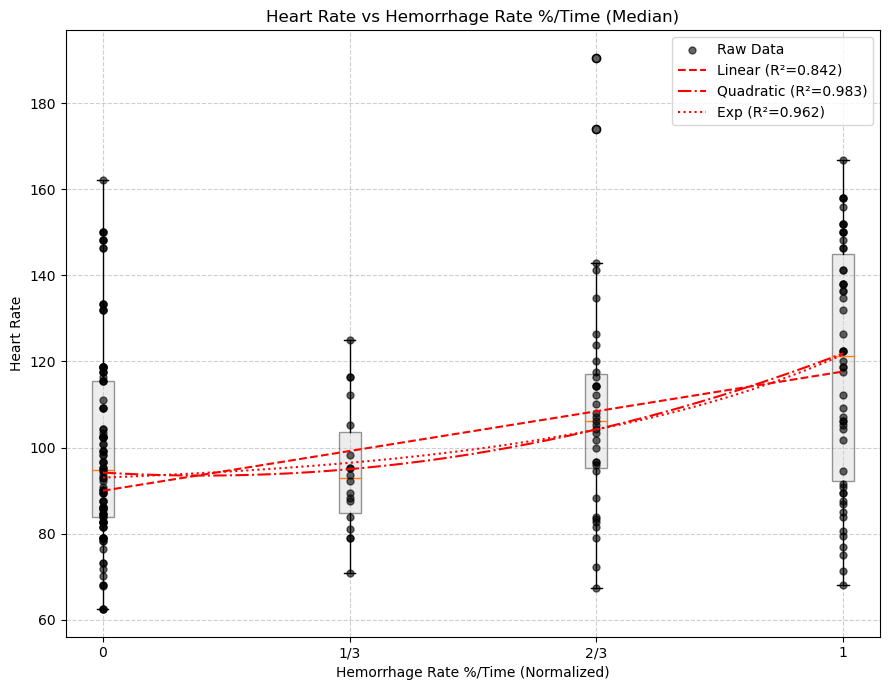

--- Heart Rate (Median) ---
Linear:    y = 27.6750x + 89.9903     R² = 0.8422
Quadratic: y = 37.9442x² + -10.2692x + 94.2063     R² = 0.9829
Exp:       y = 2.7574 * exp(2.4295x) + 90.2806     R² = 0.9618

Saved Plotly scatter plots for Heart Rate → HTML + PNG


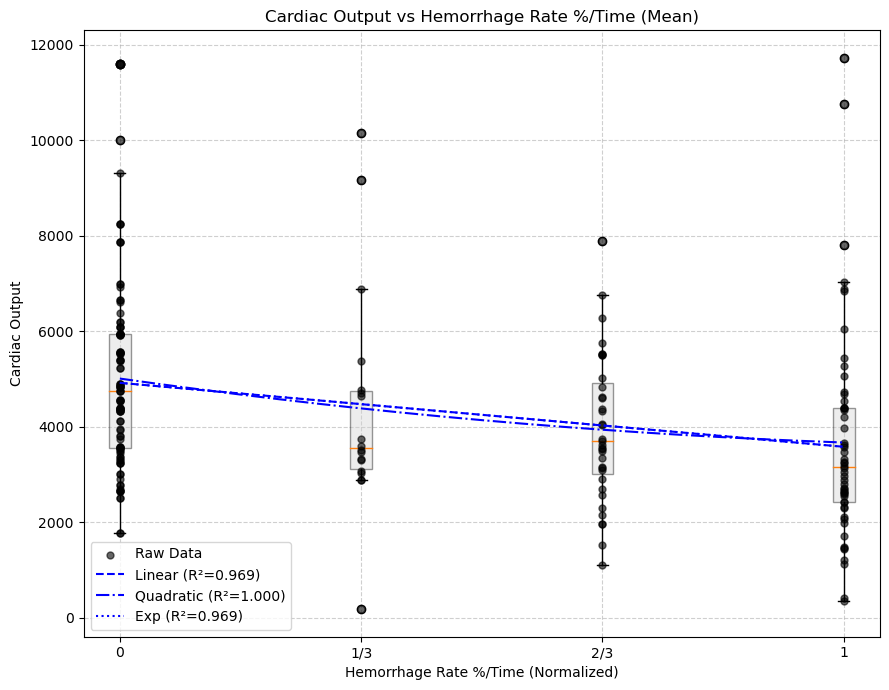

--- Cardiac Output (Mean) ---
Linear:    y = -1338.2875x + 4919.6126     R² = 0.9687
Quadratic: y = 803.2542x² + -2141.5417x + 5008.8631     R² = 0.9998
Exp:       y = -3468797.3047 * exp(0.0004x) + 3473716.8776     R² = 0.9687



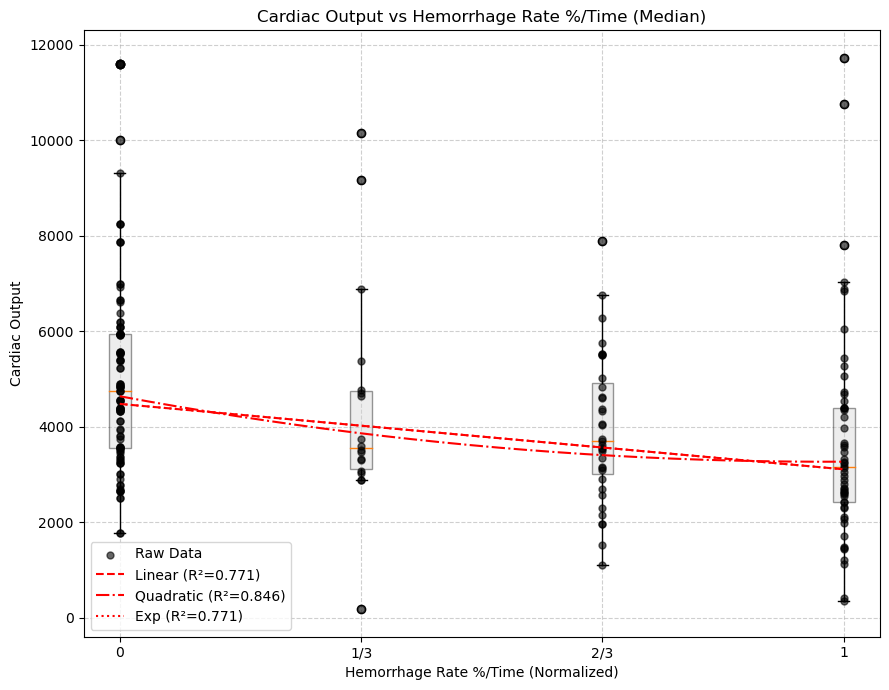

--- Cardiac Output (Median) ---
Linear:    y = -1369.3861x + 4478.8482     R² = 0.7708
Quadratic: y = 1436.9492x² + -2806.3353x + 4638.5092     R² = 0.8462
Exp:       y = -3000721.8187 * exp(0.0005x) + 3005200.5928     R² = 0.7707

Saved Plotly scatter plots for Cardiac Output → HTML + PNG


In [8]:
analyze_and_plot('PV Performance.xlsx', x_col, y_cols)